# Clinical Measures

In [3]:
from fNeuro.behavioural.data_functions import load_data
import pingouin as pg
import seaborn as sns
import bambi as bmb
import arviz as az
import matplotlib.pyplot as plt
sns.set_style('darkgrid')

Read in the data and remove outlier participant

In [10]:
df = load_data('BEACON', 'neuroimaging_behavioural_measures')

df = df.drop(df[df['t2'] == 'B2010'].index)[['t2',
                                            'edeq_global_score_t2',
                                            'anxiety_t2', 
                                            'depression_t2',
                                            'bmi_t2',
                                            'age_t2',]]
df['group'] = df['t2'].apply(lambda x: 'HC' if 'B1' in x else 'AN')
df = df.drop(df[df['t2'].str.contains('B1999')].index)

Get the cronbach alpa

In [11]:
pg.cronbach_alpha(data=df[['edeq_global_score_t2', 'depression_t2', 'anxiety_t2']])

(0.7336295014220171, array([0.622, 0.816]))

plot the measure

[Text(0.5, 1.0, 'BMI scores')]

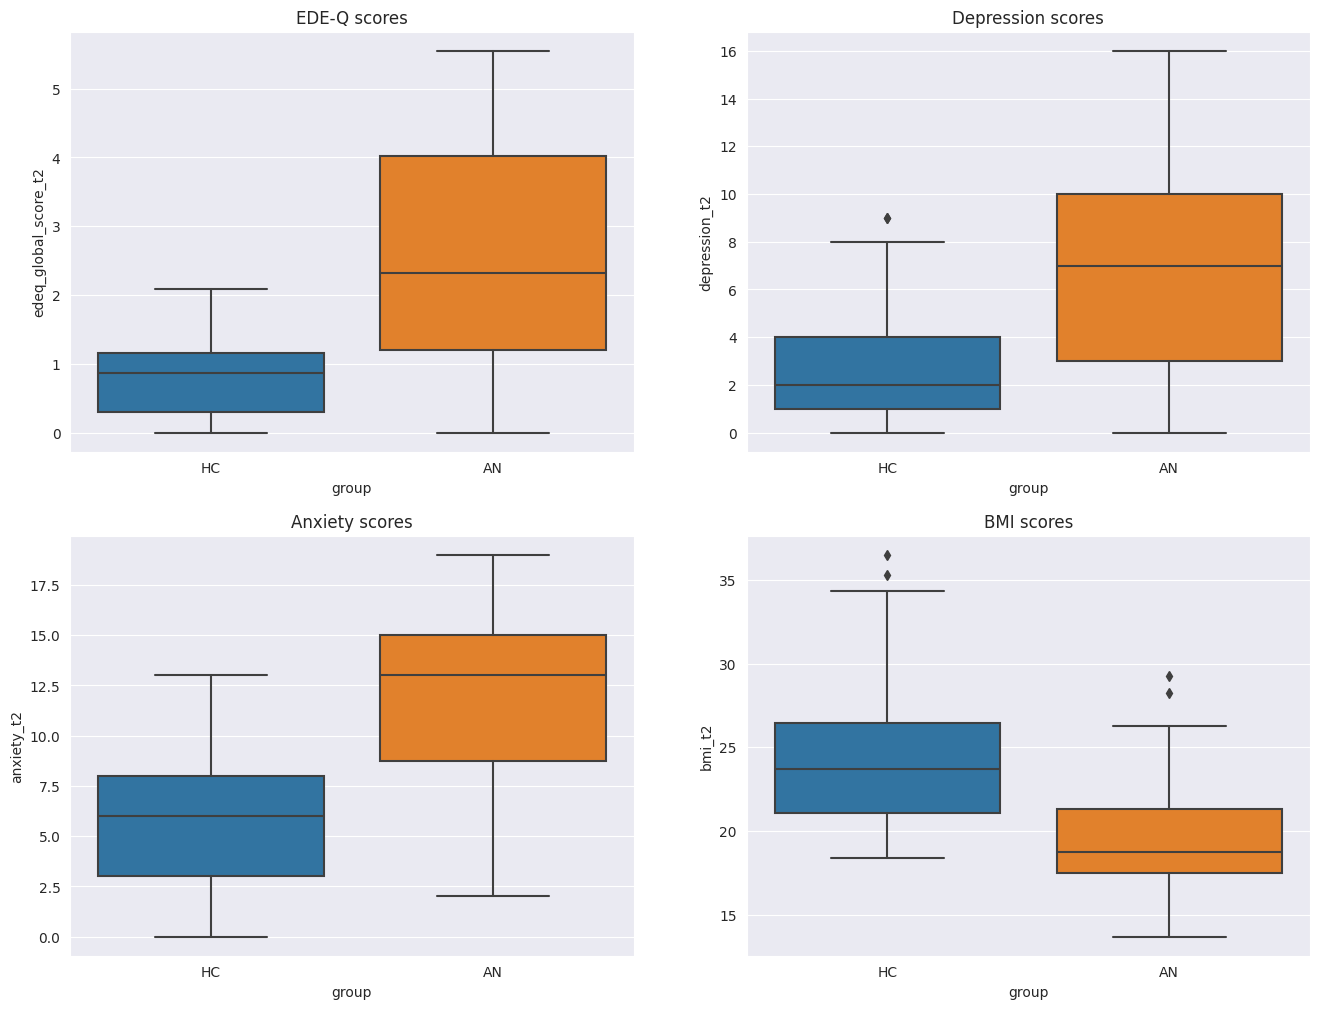

In [21]:
fig,ax = plt.subplots(2,2, figsize=(16,12))
sns.boxplot(y='edeq_global_score_t2', x='group', data=df, ax=ax[0][0]).set(title='EDE-Q scores')
sns.boxplot(y='depression_t2', x='group', data=df, ax=ax[0][1]).set(title='Depression scores')
sns.boxplot(y='anxiety_t2', x='group', data=df, ax=ax[1][0]).set(title='Anxiety scores')
sns.boxplot(y='bmi_t2', x='group', data=df, ax=ax[1][1]).set(title='BMI scores')

Get means and STD

In [13]:
groups = df.groupby('group')
groups.describe().T

group                              AN         HC
edeq_global_score_t2 count  64.000000  25.000000
                     mean    2.549219   0.866000
                     std     1.542359   0.605619
                     min     0.000000   0.000000
                     25%     1.204688   0.293750
                     50%     2.325000   0.868750
                     75%     4.025000   1.162500
                     max     5.550000   2.093750
anxiety_t2           count  64.000000  25.000000
                     mean   11.781250   6.000000
                     std     4.218135   3.253204
                     min     2.000000   0.000000
                     25%     8.750000   3.000000
                     50%    13.000000   6.000000
                     75%    15.000000   8.000000
                     max    19.000000  13.000000
depression_t2        count  64.000000  25.000000
                     mean    6.890625   2.920000
                     std     4.317249   2.900000
                     min     0.000000   0.000000
                     25%     3.000000   1.000000
                     50%     7.000000   2.000000
                     75%    10.000000   4.000000
                     max    16.000000   9.000000
bmi_t2               count  62.000000  26.000000
                     mean   19.482160  24.747140
                     std     3.303216   5.000916
                     min    13.686167  18.359375
                     25%    17.510377  21.046293
                     50%    18.714046  23.701347
                     75%    21.300444  26.466986
                     max    29.235048  36.503032
age_t2               count  65.000000  26.000000
                     mean   21.682650  22.077011
                     std     3.536103   3.075989
                     min    13.889156  17.438811
                     25%    19.368290  19.631834
                     50%    20.952792  21.045298
                     75%    24.669459  24.972195
                     max    29.089731  27.722563

Build and fit logistic regression

In [95]:
model = bmb.Model("group ~ edeq_global_score_t2 + anxiety_t2 + depression_t2 + bmi_t2 + age_t2", df, dropna=True, family='categorical')
fitted = model.fit(tune=2000, draws=2000)

Automatically removing 5/91 rows from the dataset.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, edeq_global_score_t2, anxiety_t2, depression_t2, bmi_t2, age_t2]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 18 seconds.


In [96]:
model.graph

<bound method Model.graph of Formula: group ~ edeq_global_score_t2 + anxiety_t2 + depression_t2 + bmi_t2 + age_t2
Family name: Categorical
Link: softmax
Observations: 86
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 0, sigma: 21.0994)
    edeq_global_score_t2 ~ Normal(mu: 0, sigma: 1.642)
    anxiety_t2 ~ Normal(mu: 0, sigma: 0.53)
    depression_t2 ~ Normal(mu: 0, sigma: 0.5727)
    bmi_t2 ~ Normal(mu: 0, sigma: 0.5543)
    age_t2 ~ Normal(mu: 0, sigma: 0.7272)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()
>

In [97]:
az.summary(fitted)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept[HC],-8.350,3.861,-15.623,-1.293,0.045,0.035,7775.0,5896.0,1.0
edeq_global_score_t2[HC],-0.981,0.480,-1.918,-0.125,0.006,0.005,6369.0,5254.0,1.0
anxiety_t2[HC],-0.327,0.138,-0.579,-0.068,0.002,0.001,6456.0,5486.0,1.0
depression_t2[HC],-0.122,0.149,-0.408,0.154,0.002,0.001,6809.0,5877.0,1.0
bmi_t2[HC],0.430,0.120,0.214,0.661,0.002,0.001,6037.0,5348.0,1.0
age_t2[HC],0.106,0.121,-0.119,0.336,0.001,0.001,9396.0,5383.0,1.0


array([[<AxesSubplot: title={'center': 'Intercept'}>,
        <AxesSubplot: title={'center': 'Intercept'}>],
       [<AxesSubplot: title={'center': 'edeq_global_score_t2'}>,
        <AxesSubplot: title={'center': 'edeq_global_score_t2'}>],
       [<AxesSubplot: title={'center': 'anxiety_t2'}>,
        <AxesSubplot: title={'center': 'anxiety_t2'}>],
       [<AxesSubplot: title={'center': 'depression_t2'}>,
        <AxesSubplot: title={'center': 'depression_t2'}>],
       [<AxesSubplot: title={'center': 'bmi_t2'}>,
        <AxesSubplot: title={'center': 'bmi_t2'}>],
       [<AxesSubplot: title={'center': 'age_t2'}>,
        <AxesSubplot: title={'center': 'age_t2'}>]], dtype=object)

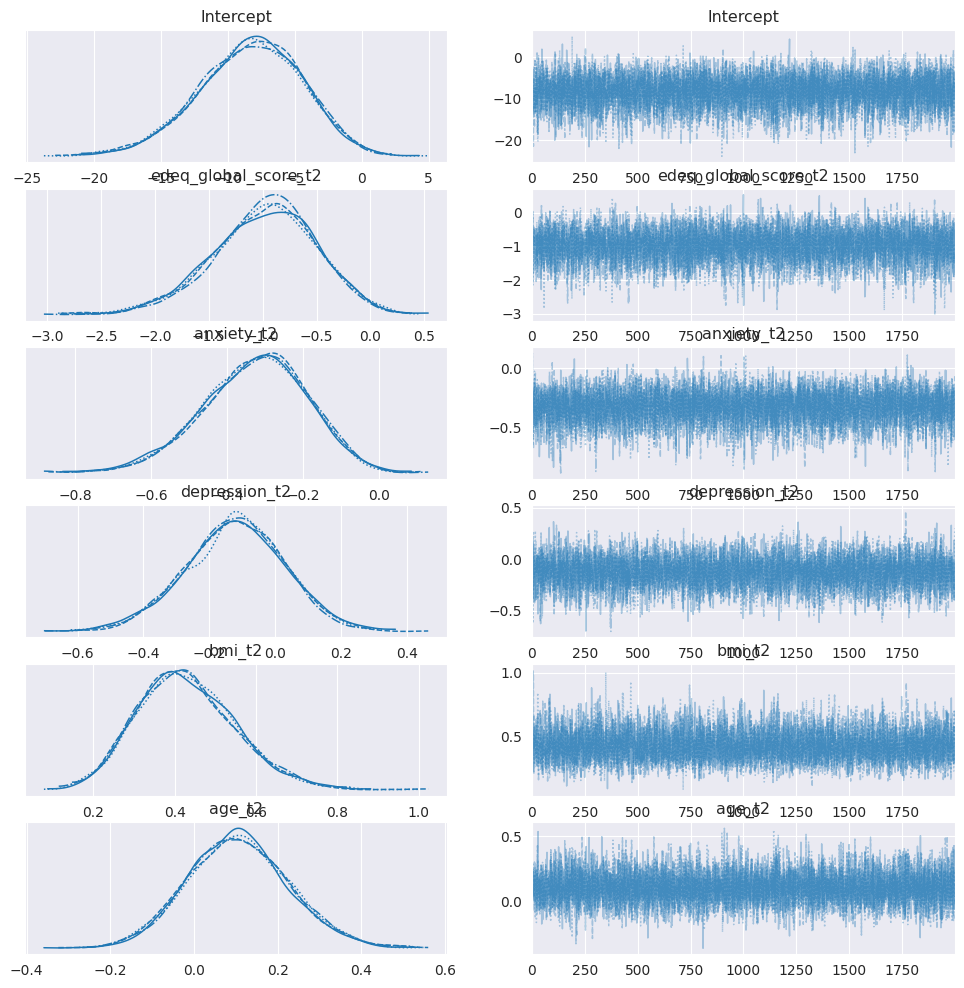

In [98]:
az.plot_trace(fitted)